# test_lens_fundamental_plane

基于 `db_zBEAMS_PEMD_100000_s1_GDB_phot_err_ManySF_TL.csv` 的 lens fundamental-plane 探针：
- 输入使用 `zL_true`, `zS_true`, `tE_true`, `r_true`, `veldisp_true`
- `gamma` 不作为观测量，仅由 parent population 抽样
- 运行 clean/noisy 两套 HMC，输出 divergence、trace、corner overlay

In [15]:
import os
os.environ.setdefault('HDF5_USE_FILE_LOCKING', 'FALSE')

from pathlib import Path
import sys

workdir = Path.cwd()
if (workdir / 'hmc_scripts').exists() is False:
    workdir = Path('/users/tianli/LensedUniverse')
os.chdir(workdir)
if str(workdir) not in sys.path:
    sys.path.insert(0, str(workdir))

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
import arviz as az

from slcosmo import tool
from hmc_scripts.corner_utils import select_corner_vars, make_overlay_corner

jax.config.update('jax_enable_x64', True)
numpyro.enable_x64()
if any(d.platform == 'gpu' for d in jax.devices()):
    numpyro.set_platform('gpu')
else:
    numpyro.set_platform('cpu')

SEED = 42
rng_np = np.random.default_rng(SEED)
np.random.seed(SEED)

TEST_MODE = False
RESULT_DIR = Path('/mnt/lustre/tianli/LensedUniverse_result')
RESULT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = Path('result')
FIG_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path(os.environ.get('SLCOSMO_DATA_DIR', str(workdir / 'data')))
DATA_CSV = DATA_DIR / 'db_zBEAMS_PEMD_100000_s1_GDB_phot_err_ManySF_TL.csv'

In [17]:
cosmo_true = {'Omegam': 0.32, 'Omegak': 0.0, 'w0': -1.0, 'wa': 0.0, 'h0': 70.0}
cosmo_prior = {
    'w0_up': 0.0, 'w0_low': -2.0,
    'wa_up': 2.0, 'wa_low': -2.0,
    'omegak_up': 1.0, 'omegak_low': -1.0,
    'h0_up': 80.0, 'h0_low': 60.0,
    'omegam_up': 0.5, 'omegam_low': 0.1,
}

LUT = np.load(DATA_DIR / 'velocity_disp_table.npy')
N1, N2, N3, N4 = LUT.shape
thetaE_grid = np.linspace(0.5, 3.0, N1)
gamma_grid = np.linspace(1.2, 2.8, N2)
Re_grid = np.linspace(0.15, 3.0, N3)
beta_grid = np.linspace(-0.5, 0.8, N4)
jampy_interp = tool.make_4d_interpolant(thetaE_grid, gamma_grid, Re_grid, beta_grid, LUT)

fp_df = pd.read_csv(DATA_CSV)
if TEST_MODE:
    n_use = 200
else:
    n_use = 50000
select_idx = rng_np.choice(fp_df.shape[0], size=min(n_use, fp_df.shape[0]), replace=False)
fp_df = fp_df.iloc[np.sort(select_idx)].reset_index(drop=True)

zl_fp = fp_df['zL_true'].to_numpy()
zs_fp = fp_df['zS_true'].to_numpy()
thetaE_true_fp = fp_df['tE_true'].to_numpy()
thetaE_err_fp = 0.01 * thetaE_true_fp
re_fp = fp_df['r_true'].to_numpy()
veldisp_true_catalog = fp_df['veldisp_true'].to_numpy()
vel_frac_err_template = fp_df['sigma_veldisp_obs'].to_numpy() / veldisp_true_catalog

_dl_fp_true, ds_fp_true, dls_fp_true = tool.dldsdls(zl_fp, zs_fp, cosmo_true, n=20)
gamma_true_fp = tool.truncated_normal(2.0, 0.2, 1.5, 2.5, zl_fp.size, random_state=rng_np)
beta_true_fp = tool.truncated_normal(0.0, 0.2, -0.4, 0.4, zl_fp.size, random_state=rng_np)
lambda_true_fp = tool.truncated_normal(1.0, 0.05, 0.8, 1.2, zl_fp.size, random_state=rng_np)
gamma_err_fp = np.full(zl_fp.size, 0.2)
n_gamma_obs = min(10000, zl_fp.size)
gamma_has_obs = np.zeros(zl_fp.size, dtype=bool)
gamma_obs_idx = rng_np.choice(zl_fp.size, size=n_gamma_obs, replace=False)
gamma_has_obs[gamma_obs_idx] = True
vel_model_fp = jampy_interp(thetaE_true_fp, gamma_true_fp, re_fp, beta_true_fp) * jnp.sqrt(ds_fp_true / dls_fp_true)
vel_true_fp = np.asarray(vel_model_fp) * np.sqrt(lambda_true_fp)
vel_err_fp = vel_frac_err_template * np.abs(vel_true_fp)

thetaE_obs_clean_fp = thetaE_true_fp.copy()
vel_obs_clean_fp = vel_true_fp.copy()
gamma_obs_clean_fp = np.zeros(zl_fp.size)
gamma_obs_clean_fp[gamma_has_obs] = gamma_true_fp[gamma_has_obs]
thetaE_obs_noisy_fp = thetaE_true_fp + rng_np.normal(0.0, thetaE_err_fp)
vel_obs_noisy_fp = rng_np.normal(vel_true_fp, vel_err_fp)
gamma_obs_noisy_fp = np.zeros(zl_fp.size)
gamma_obs_noisy_fp[gamma_has_obs] = gamma_true_fp[gamma_has_obs] + rng_np.normal(0.0, gamma_err_fp[gamma_has_obs])

def build_data(theta_E_obs, vel_obs, gamma_obs):
    return {
        'zl': zl_fp,
        'zs': zs_fp,
        'theta_E': theta_E_obs,
        'theta_E_err': thetaE_err_fp,
        're': re_fp,
        'vel_obs': vel_obs,
        'vel_err': vel_err_fp,
        'gamma_obs': gamma_obs,
        'gamma_err': gamma_err_fp,
        'gamma_has_obs': gamma_has_obs,
    }

fp_data_clean = build_data(thetaE_obs_clean_fp, vel_obs_clean_fp, gamma_obs_clean_fp)
fp_data_noisy = build_data(thetaE_obs_noisy_fp, vel_obs_noisy_fp, gamma_obs_noisy_fp)
print('N_lens =', zl_fp.shape[0], 'N_gamma_obs =', int(gamma_has_obs.sum()))

N_lens = 50000 N_gamma_obs = 10000


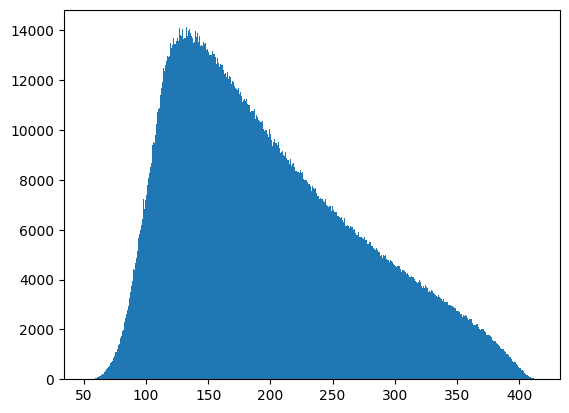

In [30]:
_ = plt.hist(LUT.flatten(), bins = 1000)

(array([6.100e+01, 7.330e+02, 2.735e+03, 4.782e+03, 5.861e+03, 5.894e+03,
        4.956e+03, 4.210e+03, 3.559e+03, 2.839e+03, 2.255e+03, 1.832e+03,
        1.529e+03, 1.290e+03, 1.029e+03, 8.860e+02, 7.490e+02, 5.940e+02,
        5.220e+02, 4.480e+02, 3.840e+02, 3.260e+02, 2.890e+02, 2.770e+02,
        2.300e+02, 2.160e+02, 1.880e+02, 1.690e+02, 1.430e+02, 1.300e+02,
        1.040e+02, 9.200e+01, 1.120e+02, 8.800e+01, 8.100e+01, 7.300e+01,
        7.600e+01, 6.100e+01, 5.100e+01, 4.200e+01, 3.000e+01, 2.100e+01,
        1.600e+01, 1.400e+01, 9.000e+00, 7.000e+00, 5.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([0.16136491, 0.17739502, 0.19342513, 0.20945525, 0.22548536,
        0.24151547, 0.25754558, 0.27357569, 0.28960581, 0.30563592,
        0.32166603, 0.33769614, 0.35372625, 0.36975637, 0.38578648,
        0.40181659, 0.4178467 , 0.43387681, 0.44990693, 0.46593704,
        0.48196715, 0.49799726, 0.51402737, 0.53005749, 0.5460876 ,
        0.56211771, 0.57814782, 0.59

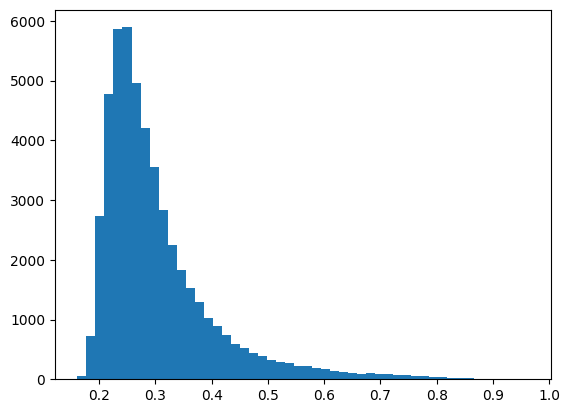

In [32]:
plt.hist(vel_frac_err_template, bins = 50)
# plt.xlim([1.5, 2.5])
# plt.ylim([0, 1000])

In [ ]:
def cosmology_model(kind, cosmo_prior, sample_h0=True):
    cosmo = {
        'Omegam': numpyro.sample('Omegam', dist.Uniform(cosmo_prior['omegam_low'], cosmo_prior['omegam_up'])),
        'Omegak': 0.0,
        'w0': -1.0,
        'wa': 0.0,
        'h0': 70.0,
    }
    if kind in ['wcdm', 'owcdm', 'waw0cdm', 'owaw0cdm']:
        cosmo['w0'] = numpyro.sample('w0', dist.Uniform(cosmo_prior['w0_low'], cosmo_prior['w0_up']))
    if kind in ['waw0cdm', 'owaw0cdm']:
        cosmo['wa'] = numpyro.sample('wa', dist.Uniform(cosmo_prior['wa_low'], cosmo_prior['wa_up']))
    if kind in ['owcdm', 'owaw0cdm']:
        cosmo['Omegak'] = numpyro.sample('Omegak', dist.Uniform(cosmo_prior['omegak_low'], cosmo_prior['omegak_up']))
    if sample_h0:
        cosmo['h0'] = numpyro.sample('h0', dist.Uniform(cosmo_prior['h0_low'], cosmo_prior['h0_up']))
    return cosmo


def fundamental_plane_model(fp_data):
    cosmo = cosmology_model('waw0cdm', cosmo_prior, sample_h0=True)

    lambda_mean = numpyro.sample('lambda_mean', dist.Uniform(0.9, 1.1))
    lambda_sigma = numpyro.sample('lambda_sigma', dist.TruncatedNormal(0.05, 0.5, low=0.0, high=0.2))
    gamma_mean = numpyro.sample('gamma_mean', dist.Uniform(1.4, 2.6))
    gamma_sigma = numpyro.sample('gamma_sigma', dist.TruncatedNormal(0.2, 0.2, low=0.0, high=0.4))
    beta_mean = numpyro.sample('beta_mean', dist.Uniform(-0.3, 0.3))
    beta_sigma = numpyro.sample('beta_sigma', dist.TruncatedNormal(0.2, 0.2, low=0.0, high=0.4))

    _dl, ds_fp, dls_fp = tool.dldsdls(fp_data['zl'], fp_data['zs'], cosmo, n=20)
    with numpyro.plate('fundamental_plane', len(fp_data['zl'])):
        gamma_fp = numpyro.sample('gamma_fp', dist.TruncatedNormal(gamma_mean, gamma_sigma, low=1.4, high=2.6))
        beta_fp = numpyro.sample('beta_fp', dist.TruncatedNormal(beta_mean, beta_sigma, low=-0.4, high=0.4))
        lambda_fp = numpyro.sample('lambda_fp', dist.TruncatedNormal(lambda_mean, lambda_sigma, low=0.8, high=1.2))
        thetaE_fp = numpyro.sample('thetaE_fp', dist.Normal(fp_data['theta_E'], fp_data['theta_E_err']))

        v_interp_fp = jampy_interp(thetaE_fp, gamma_fp, fp_data['re'], beta_fp)
        vel_pred_fp = v_interp_fp * jnp.sqrt(ds_fp / dls_fp) * jnp.sqrt(lambda_fp)
        gamma_obs_mask = jnp.asarray(fp_data['gamma_has_obs'])
        gamma_obs_used = jnp.where(gamma_obs_mask, fp_data['gamma_obs'], gamma_fp)
        numpyro.sample(
            'gamma_fp_like',
            dist.Normal(gamma_fp, fp_data['gamma_err']).mask(gamma_obs_mask),
            obs=gamma_obs_used,
        )
        numpyro.sample('vel_fp_like', dist.Normal(vel_pred_fp, fp_data['vel_err']), obs=fp_data['vel_obs'])

In [ ]:
def run_mcmc(data, key, tag):
    if TEST_MODE:
        num_warmup, num_samples, num_chains, chain_method = 200, 200, 2, 'sequential'
    else:
        num_warmup, num_samples, num_chains, chain_method = 500, 1500, 4, 'vectorized'

    nuts = NUTS(fundamental_plane_model, target_accept_prob=0.95)
    mcmc = MCMC(
        nuts,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
        chain_method=chain_method,
        progress_bar=True,
    )
    mcmc.run(key, fp_data=data)

    extra = mcmc.get_extra_fields(group_by_chain=True)
    n_div = int(np.asarray(extra['diverging']).sum())
    print(f'[{tag}] divergences: {n_div}')

    posterior = mcmc.get_samples(group_by_chain=True)
    inf_data = az.from_dict(posterior=posterior)
    az.to_netcdf(inf_data, RESULT_DIR / f'lens_fp_{tag}.nc')

    trace_vars = ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma']
    trace_vars = [v for v in trace_vars if v in inf_data.posterior and inf_data.posterior[v].ndim == 2]
    if trace_vars:
        trace_axes = az.plot_trace(inf_data, var_names=trace_vars, compact=False)
        trace_fig = np.asarray(trace_axes).ravel()[0].figure
        trace_fig.savefig(FIG_DIR / f'lens_fp_trace_{tag}.pdf', dpi=200, bbox_inches='tight')
        plt.close(trace_fig)
    return inf_data


key = random.PRNGKey(42)
key_clean, key_noisy = random.split(key)

idata_clean = run_mcmc(fp_data_clean, key_clean, 'clean')
idata_noisy = run_mcmc(fp_data_noisy, key_noisy, 'noisy')

In [ ]:
corner_vars = select_corner_vars(
    idata_clean,
    idata_noisy,
    ['h0', 'Omegam', 'w0', 'wa', 'lambda_mean', 'lambda_sigma', 'gamma_mean', 'gamma_sigma', 'beta_mean', 'beta_sigma'],
)
make_overlay_corner(idata_clean, idata_noisy, corner_vars, FIG_DIR / 'lens_fp_corner_overlay.pdf')

print('Saved:')
print(RESULT_DIR / 'lens_fp_clean.nc')
print(RESULT_DIR / 'lens_fp_noisy.nc')
print(FIG_DIR / 'lens_fp_trace_clean.pdf')
print(FIG_DIR / 'lens_fp_trace_noisy.pdf')
print(FIG_DIR / 'lens_fp_corner_overlay.pdf')

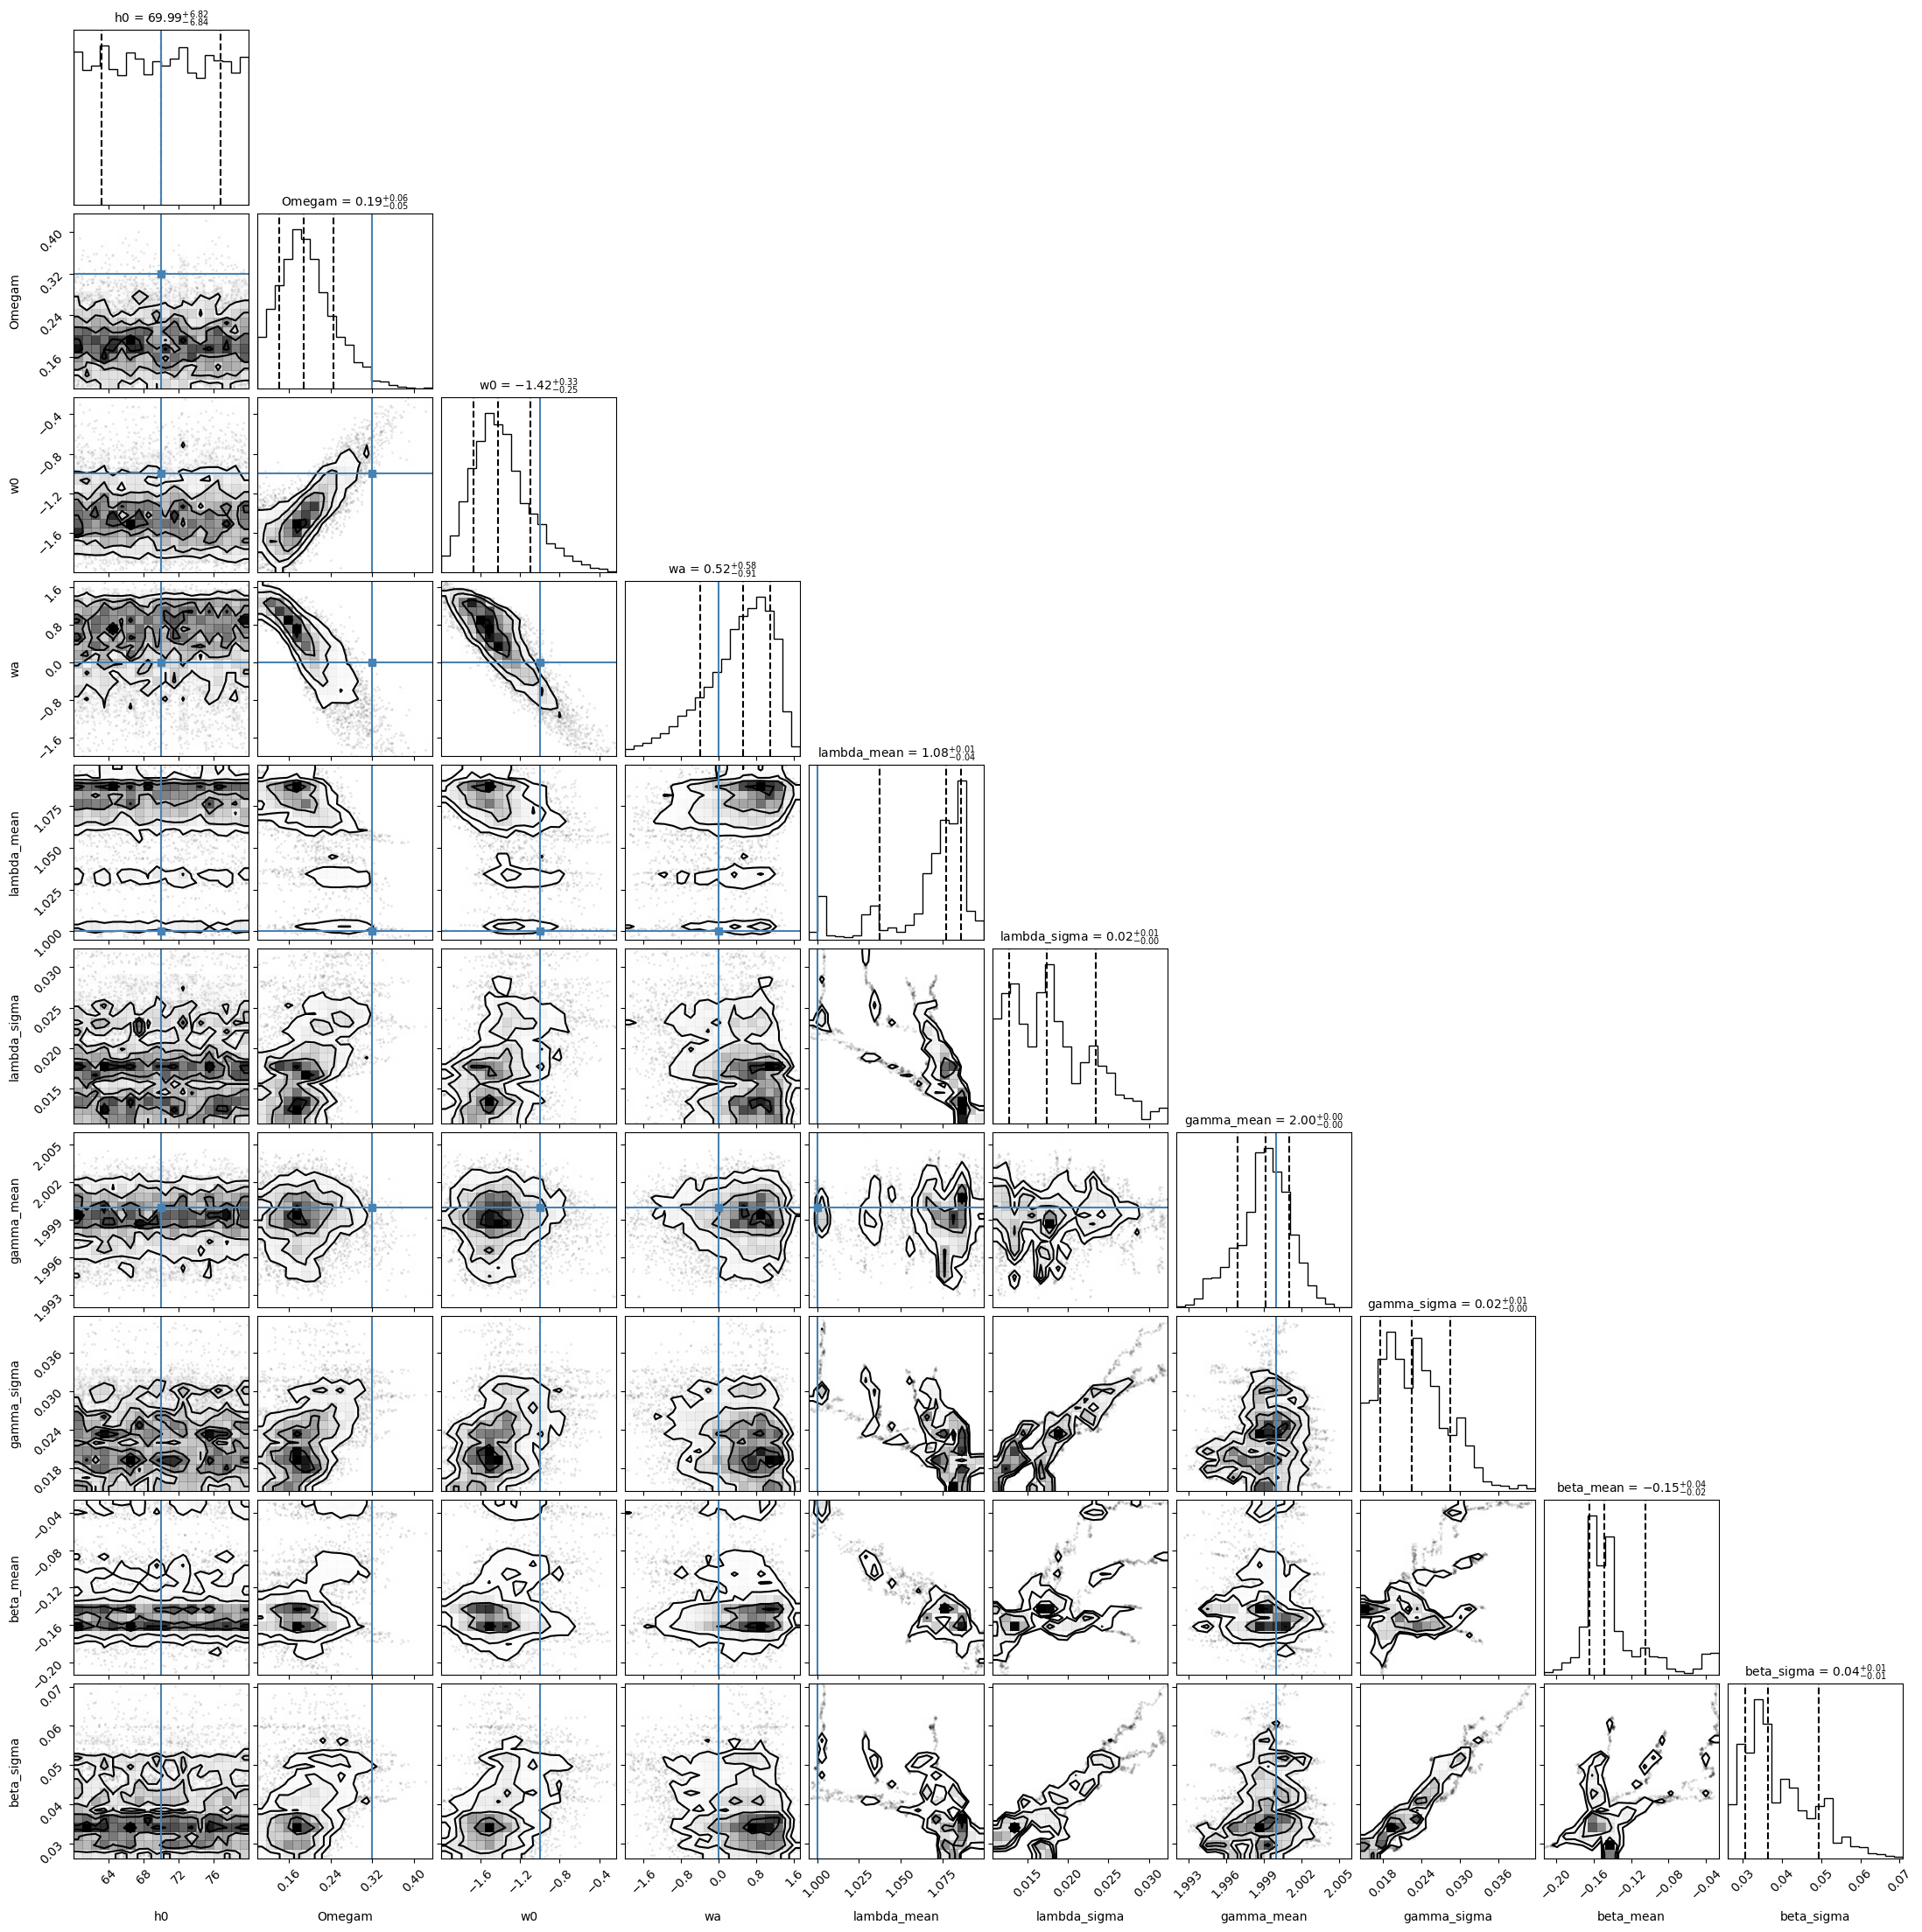

In [14]:
import arviz as az
import numpy as np
import corner
import matplotlib.pyplot as plt

path = "/mnt/lustre/tianli/LensedUniverse_result/lens_fp_clean.nc"
idata = az.from_netcdf(path)

vars_ = ['h0', 'Omegam', 'w0', 'wa',
         'lambda_mean', 'lambda_sigma',
         'gamma_mean', 'gamma_sigma',
         'beta_mean', 'beta_sigma']

post = idata.posterior
missing = [v for v in vars_ if v not in post.data_vars]
if missing:
    raise KeyError(f"Missing in idata.posterior: {missing}\nAvailable: {list(post.data_vars)}")

# --- truths: fill these with your ground-truth / injected values ---
truth_dict = {
    'h0': 70, 'Omegam': 0.32, 'w0': -1, 'wa': 0,
    'lambda_mean': 1, 'lambda_sigma': 0.05,
    'gamma_mean': 2, 'gamma_sigma': 0.2,
    'beta_mean': 0, 'beta_sigma': 0.5,
}
truths = [truth_dict[v] for v in vars_]  # order must match vars_

# stack chains/draws -> (nsamples, nvars)
samples = np.column_stack([
    np.asarray(post[v].stack(sample=("chain", "draw")).values).reshape(-1)
    for v in vars_
])

fig = corner.corner(
    samples,
    labels=vars_,
    truths=truths,                 # <- adds truth lines/markers
    show_titles=True,
    title_kwargs={"fontsize": 10},
    quantiles=[0.16, 0.5, 0.84],
)
plt.show()
